In [ ]:
Pkg.add("LibExpat"); using LibExpat
Pkg.add("Winston"); using Winston

Pkg.clone("MXNet");
ENV["MXNET_HOME"] = "/mxnet"
Pkg.add("GraphPlot");
Pkg.add("NetworkViz");
Pkg.add("PyPlot");
Pkg.add("MLBase")

In [ ]:
Pkg.add("GraphPlot");

In [ ]:
using MXNet
using GraphPlot

In [ ]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs

In [ ]:
osm_fn = "northern_stockholm.osm"

In [ ]:
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph(osm_fn);

In [ ]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x -> vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon)
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = nodesLLA[k].coords.lat
end

In [ ]:
println(maximum(locs_x))
println(minimum(locs_x))
println(maximum(locs_y))
println(minimum(locs_y))

In [ ]:
edge_weights = Dict()

for (edge, info_dict) in edgeDict
    edgeDict[edge][:bad_weather] = false
    num_vehicles = Int(ceil(randexp()) * 10)
    info_dict[:num_vehicles] = num_vehicles
    edge_weight = generate_weights_with_factors(info_dict[:segmentlen], 
                                                info_dict[:speed],
                                                num_vehicles=num_vehicles)
    
    info_dict[:weight] = edge_weight
    edge_weights[(edge.src, edge.dst)] = edge_weight
end

max_edge_weight = maximum(values(edge_weights))
min_edge_weight = minimum(values(edge_weights))
println(max_edge_weight)
println(min_edge_weight)

In [ ]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    # normalize weights
    g_distmx[edge.src, edge.dst] = (info_dict[:weight] - min_edge_weight) / (max_edge_weight - min_edge_weight)
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y)

# Below is a very neat plot of northern Stockholm road network

In [ ]:
gplot(graph, locs_x, -locs_y, arrowlengthfrac=0.0)

In [ ]:
calc_cosine_dist(p1, p2) = dot(p1, p2) / (norm(p1) * norm(p2))

calc_euclidean_dist(p1, p2) = norm(p1 - p2)

function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 7))
    
    x_u = norm_locs_x[node]
    y_u = norm_locs_y[node]
    x_dst = norm_locs_x[dst]
    y_dst = norm_locs_y[dst]

    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        x_v = norm_locs_x[out_neighbor]
        y_v = norm_locs_y[out_neighbor]
        
        ret[idx, 1] = 0.0
        ret[idx, 2] = g_distmx[node, out_neighbor]
        ret[idx, 3] = calc_cosine_dist([x_v-x_u, y_v-y_u], [x_dst-x_u, y_dst-y_u])
        ret[idx, 4] = calc_euclidean_dist([x_v, y_v], [x_dst, y_dst])
        ret[idx, 5] = x_v
        ret[idx, 6] = y_v
        
        ret[idx, end] = out_neighbor
        
    end
    
    return (ret, x_dst, y_dst)
    
end

In [ ]:
function generate_stochastic_dataset(G; sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        (src, dst) in keys(edge_weights) && continue    
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && break
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

In [ ]:
@time begin
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph, sample_size_lower_bound=10000, verbose_frequent=2000);
end
@assert length(features) == length(labels) == sample_cnt

In [ ]:
pair_path_dict

In [ ]:
max_path_len = maximum(map(e -> length(e), values(pair_path_dict)))
println(max_path_len)

# Is data augmentation really helpful?
Perhap when overdone, data augmentation only makes it harder to train.
As of this moment, data augmentation will be ignored.

In [ ]:
function find_label_idx(feature, label)
    
    num_row = size(feature)[1]
    ret_idx = 1
    
    for row_idx in 1:num_row
        if feature[row_idx, end] == label
            ret_idx = row_idx
        end
    end
    
    ret_idx
end

function augment_dataset(X, y; aug_multiple=20, verbose_frequent=500)
    
    org_sample_size = length(y)
    aug_sample_size = aug_multiple * org_sample_size
    feature_size = max_out_degree * 6 + 2
    
    X_aug, y_aug = zeros(Float32, aug_sample_size, feature_size), zeros(Int, aug_sample_size)
    indices = 1:max_out_degree
    
    cur_sample_idx = 1
    
    for pair in zip(X, y)
        feature = pair[1]
        label = pair[2]
        
        for _ in 1:aug_multiple
             
#             shuffled_indices = shuffle(MersenneTwister(now().instant.periods.value), indices)
            shuffled_indices = indices
            feature_tmp = feature[1][shuffled_indices, :]
            label_tmp = find_label_idx(feature_tmp, label)
            
            feature_tmp = transpose(feature_tmp[:, 1:end-1])

            
            X_aug[cur_sample_idx, :] = push!(vcat(feature_tmp...), feature[2], feature[3])
            y_aug[cur_sample_idx] = label_tmp - 1
            
            cur_sample_idx += 1
            
            if cur_sample_idx % verbose_frequent == 0
                println("Processed $(cur_sample_idx) samples")
            end
        end
    end
    
    return transpose(X_aug), y_aug
end

In [ ]:
X, y = augment_dataset(features, labels, aug_multiple=1, verbose_frequent=5000)

println(size(X))
println(size(y))

In [ ]:
count(x -> x == 0, y)

In [ ]:
split_at = [rand() > 0.2 for i in 1:length(y)]

X_train = X[:, split_at]
y_train = y[split_at]

X_val = X[:, .!split_at]
y_val = y[.!split_at];

In [ ]:
println(size(X_train))
println(size(y_train))
println(size(X_val))
println(size(y_val))

In [ ]:
function build_model(context)

    mlp = @mx.chain mx.Variable(:data)             =>
      mx.FullyConnected(name=:fc1, num_hidden=1024) =>
      mx.Activation(name=:relu1, act_type=:relu)   =>
      mx.FullyConnected(name=:fc2, num_hidden=512)  =>
      mx.Activation(name=:relu2, act_type=:relu)   =>
      mx.FullyConnected(name=:fc3, num_hidden=max_out_degree)  =>
      mx.SoftmaxOutput(name=:softmax)
    
    return mx.FeedForward(mlp, context=context)
end

# First overfit the entire dataset

In [ ]:
batch_size = 128

train_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size, shuffle=true)
val_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size);

In [ ]:
model = build_model(mx.gpu())

In [ ]:
mx.fit(model, mx.ADAM(),
    train_provider,
    n_epoch=150,
    eval_data=val_provider,
    verbosity=3)

In [ ]:
using MLBase

pred = mx.predict(model, 
        mx.ArrayDataProvider(X, batch_size=batch_size), verbosity=0)

pred = map(i -> indmax(pred[:, i]), 1:length(y))

confusmat(max_out_degree, y+1, pred)

In [ ]:
function nn_infer_next_node(G, parent, cur_node, src, dst, model)

    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    real_input_vec = push!(vcat(transpose(input_vec[:, 1:end-1])...), x_dst, y_dst)
    
    pred = mx.predict(model, mx.ArrayDataProvider(reshape(real_input_vec, :, 1)), verbosity=0)
    pred_idx = findmax(pred)[2]
    neighbor = Int(input_vec[pred_idx, end])
    
    if neighbor == 0
        
        avaliable_neighbors = filter(x -> x > 0, input_vec[:, end])
        
        if length(avaliable_neighbors) != 0
            println("Invalid prediction, randomizing next node")
            neighbor = Int(avaliable_neighbors[rand(1:end)])
        else
            # TODO the algorithm can be made smarter
            return -1, 0
        end
    end
    
    return neighbor, edge_weights[(cur_node, neighbor)]
end

function dijkstra_path_finder(G, src, dst, model; invalid_path_len_threshold=200)
    
    path = [src]
    parent_node = 0
    cur_node = src
    total_weights = 0.0
    
    while true
        if length(path) >= invalid_path_len_threshold
            return path, total_weights, false
        end
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        
        if next_node == -1
            
            if !has_edge(G, (cur_node, parent_node))
                return path, total_weights, false
            end
            
            println("No available node to choose, turning back")
            parent_node, cur_node = cur_node, parent_node
            continue
        end
        
        total_weights += weight
        push!(path, next_node)
        
        if next_node == dst
            return path, total_weights, true
        end
        
        parent_node = cur_node
        cur_node = next_node
    end

end

function build_ground_truth_path(src, dst)
    
    edges = pair_path_dict[(src, dst)]
    
    path = [edges[1].src]
    
    for edge in edges
       push!(path, edge.dst) 
    end
    
    path
end

In [ ]:
function calc_statistics(G, num_to_test)
   
    found_cnt = 0
    opt_path_cnt = 0
    
    pairs = shuffle(collect(keys(pair_path_dict)))[1:num_to_test]
    
    for pair in pairs
        src, dst = pair[1], pair[2]

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model, 
                                invalid_path_len_threshold=max_path_len * 2)
        dijkstra_path = build_ground_truth_path(src, dst)
        
        found == false && continue
        
        found_cnt += 1
        
        if nn_path == dijkstra_path
            opt_path_cnt += 1
        else
            println(nn_path)
            println(dijkstra_path)
        end
    end
    
    return found_cnt, opt_path_cnt
end

In [ ]:
function print_paths_statistics(G, num_to_test)

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, num_to_test)
    
    @printf "%d out of %d can find path: %f\n" found_cnt num_total_path float(found_cnt)/num_total_path
    @printf "%d out of %d can find optimal path: %f\n" opt_path_cnt found_cnt float(opt_path_cnt)/found_cnt
    @printf "%d out of %d all paths can find optimal paths: %f\n" opt_path_cnt num_total_path float(opt_path_cnt)/num_total_path
    
end

In [ ]:
print_paths_statistics(graph, 10)

# N.B.

When the model is able to find the optimal path
with high probability, the model has learned well.

In [ ]:
percentage_found = []
percentage_opt_found = []
percentage_opt_all = []

for _ in 1:10
    num_total_path = 200
    
    found_cnt, opt_path_cnt = calc_statistics(graph, num_total_path)
    push!(percentage_found, found_cnt/num_total_path)
    push!(percentage_opt_found, opt_path_cnt/found_cnt)
    push!(percentage_opt_all, opt_path_cnt/num_total_path)
end

In [ ]:
using PyPlot

boxplot([percentage_found, percentage_opt_found, percentage_opt_all],
        labels=["found/all", "opt/found", "opt/all"]) # Basic

In [ ]:
using PyPlot
using PyCall

@pyimport networkx as nx

distmx = fill(Inf, (nv(graph), nv(graph)))

function build_networkx_graph(julia_graph)
    
    
    
    G = nx.DiGraph()
    
    for (edge, _) in edgeDict
#         print(node, coord[0], coord[1])
        weight = (0.5 * rand() + 0.5) * 
                        calc_euclidean_dist([norm_locs_x[edge.src], norm_locs_y[edge.src]], 
                                            [norm_locs_x[edge.dst], norm_locs_y[edge.dst]])
        nx.add_path(G, [edge.src, edge.dst], weight=weight)
        distmx[edge.src, edge.dst] = weight
    end
    
    G
end

function build_ground_truth_path(path_edges)
    
    path = [path_edges[1].src]
    edges = []
    
    for edge in path_edges
        push!(path, edge.dst)
        push!(edges, (edge.src, edge.dst))
    end
    
    return path, edges
end

function plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)
    
    G = build_networkx_graph(graph)
    
    pos = Dict()

    for node in 1:nv(graph)
        pos[node] = (locs_x[node], locs_y[node])
    end

    node_color = ["c" for _ in 1:nv(graph)];
    node_size = [0.01 for _ in 1:nv(graph)];
    
    # Mark ground truth path
    node_color[gt_path_nodes[end]] = "g"
    node_color[gt_path_nodes[1]] = "k"

    node_size[gt_path_nodes[1]] = 20
    node_size[gt_path_nodes[end]] = 20

    for node in gt_path_nodes[2:end-1]
        node_color[node] = "r"
        node_size[node] = 1
    end

    # Mark nn path
    for node in nn_path_nodes[2:end-1]
        node_color[node] = "b"
        node_size[node] = 1
    end
    
    nx.draw_networkx(G, pos=pos, 
                    with_labels=false,
                    nodelist=1:nv(graph),
                    node_size=node_size, 
                    width=0.01,
                    arrows=false,
                    node_color=node_color)
end

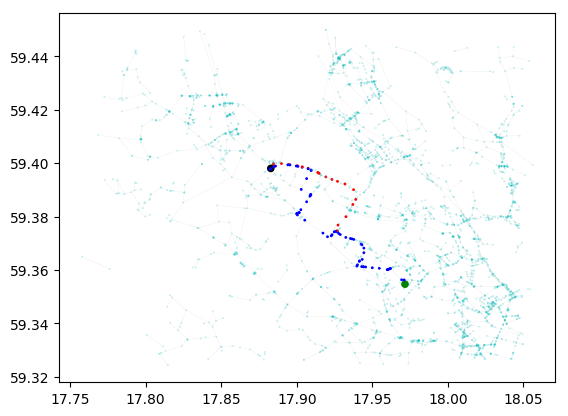

In [23]:
gt_path_nodes = [1417, 2228, 763, 3, 3475, 2886, 1173, 2173, 1271, 1274, 2121, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 13, 1502, 2216, 1101, 1640, 127, 1039, 3351, 2764, 1562, 1667, 2078, 665, 551, 2747, 2856, 2432, 2556, 3034, 1899, 561, 2583, 3176, 80, 2723, 2514, 1960, 1099, 838, 1771, 1249, 999, 1804, 2748, 2905, 3356, 1123, 1309]
nn_path_nodes = [1417, 2228, 2855, 763, 3, 3475, 2886, 1173, 2181, 2932, 2262, 2720, 1050, 252, 3078, 1033, 1279, 2226, 2964, 434, 3131, 850, 2898, 369, 739, 1492, 1780, 1996, 2653, 2910, 251, 2524, 483, 545, 2832, 2486, 596, 3415, 127, 1039, 3351, 2764, 1562, 1667, 2078, 665, 551, 2747, 2856, 2432, 2556, 3034, 1899, 561, 2583, 3176, 80, 2723, 2514, 1960, 1099, 838, 1771, 1249, 999, 1804, 2748, 2905, 3356, 1123, 1309];

plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)